##*AI LAB PROJECT BY WARID,AIMASH AND AMMAR*

##TASK 1: PREPROCESSING PIPELINE

In [1]:
import pandas as pd

# CHANGE THESE FILENAMES to match what you upload
train_df = pd.read_excel("Symptom Classification dataset - 2 -- Train.xlsx")
val_df   = pd.read_excel("Symptom Classification dataset - 2 -- Val.xlsx")
test_df  = pd.read_excel("Symptom Classification dataset - 2 -- Test.xlsx")

train_df.head()


,text,labs,partition
0,"Sally is around the same age, 25 I assume, (ca...",0,Train
1,Every once and a while I will get this over wh...,1,Train
2,Then about 25 minutes later I got a message fr...,0,Train
3,"However, today I was sitting at work and for w...",1,Train
4,"I was nice, and it got me no where, so I was r...",1,Train


In [13]:
print("Columns:", train_df.columns.tolist())
print(train_df.isnull().sum())        # missing values
print(train_df['labs'].value_counts())  # CHANGE label column name if needed


Columns: ['text', 'labs', 'partition']
text         0
labs         0
partition    0
dtype: int64
labs
1    1785
0    1620
Name: count, dtype: int64


In [14]:
!pip install -q nltk spacy wordcloud tqdm
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 111.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
import re, string
from tqdm import tqdm
tqdm.pandas()

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')   # <-- NEW important fix
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # 1. Convert to lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r"http\S+|www\.\S+", " ", text)

    # 3. Remove emails
    text = re.sub(r"\S+@\S+", " ", text)

    # 4. Remove numbers
    text = re.sub(r"\d+", " ", text)

    # 5. Remove punctuation
    text = text.translate(str.maketrans(string.punctuation, " "*len(string.punctuation)))

    # 6. Tokenize
    tokens = word_tokenize(text)

    # 7. Remove stopwords + short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]

    # 8. Lemmatize using spaCy
    doc = nlp(" ".join(tokens))
    tokens = [token.lemma_ for token in doc]

    # 9. Join back
    return " ".join(tokens)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
text_col = "text"   # CHANGE to your actual text column
label_col = "label" # CHANGE if different

train_df["clean_text"] = train_df[text_col].progress_apply(preprocess_text)
val_df["clean_text"]   = val_df[text_col].progress_apply(preprocess_text)
test_df["clean_text"]  = test_df[text_col].progress_apply(preprocess_text)


100%|██████████| 1136/1136 [00:06<00:00, 179.73it/s]


In [17]:
train_df.to_csv("train_clean.csv", index=False)
val_df.to_csv("val_clean.csv", index=False)
test_df.to_csv("test_clean.csv", index=False)


##TASK 2: EXPLORARY DATA ANALYSIS(N-GRAMS.WORDCLOUDS AND POS)

In [18]:
import pandas as pd

train = pd.read_csv("train_clean.csv")
val   = pd.read_csv("val_clean.csv")
test  = pd.read_csv("test_clean.csv")


In [19]:
train['labs'].value_counts()


,count
labs,
1,1785
0,1620


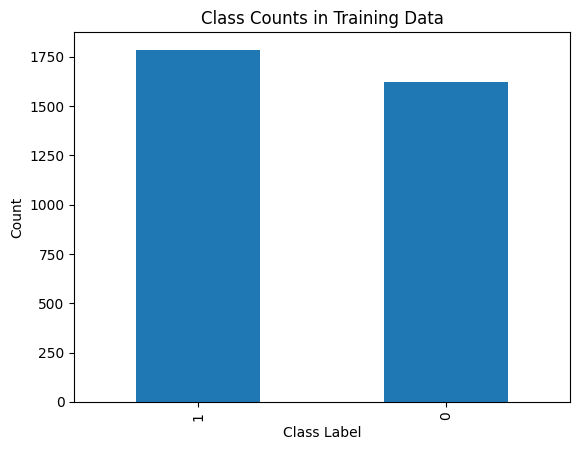

In [20]:
import matplotlib.pyplot as plt

train['labs'].value_counts().plot(kind='bar')
plt.title("Class Counts in Training Data")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()


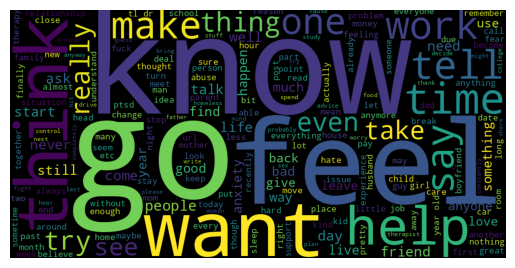

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
all_text = " ".join(train['clean_text'])
wc = WordCloud(width=1000, height=500).generate(all_text)

plt.imshow(wc)
plt.axis("off")
plt.show()



Now We will generate:

Unigrams (single words)

Bigrams (two-word phrases)

Trigrams (three-word phrases)

The simplest way is using CountVectorizer

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1,1))
X = vectorizer.fit_transform(train_df['clean_text'])

vocab = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

# Combine vocab + counts
unigram_freq = dict(zip(vocab, counts))

# Show top 10
sorted(unigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]


[('get', np.int64(1848)),
 ('go', np.int64(1599)),
 ('like', np.int64(1484)),
 ('feel', np.int64(1402)),
 ('know', np.int64(1309)),
 ('time', np.int64(1132)),
 ('want', np.int64(981)),
 ('make', np.int64(903)),
 ('would', np.int64(876)),
 ('help', np.int64(853))]

In [23]:
vectorizer = CountVectorizer(ngram_range=(2,2))
X = vectorizer.fit_transform(train_df['clean_text'])

vocab = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

bigram_freq = dict(zip(vocab, counts))
sorted(bigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]


[('feel like', np.int64(440)),
 ('tl dr', np.int64(140)),
 ('year old', np.int64(126)),
 ('go back', np.int64(96)),
 ('mental health', np.int64(95)),
 ('panic attack', np.int64(93)),
 ('anyone else', np.int64(89)),
 ('year ago', np.int64(87)),
 ('make feel', np.int64(84)),
 ('do not', np.int64(81))]

In [24]:
vectorizer = CountVectorizer(ngram_range=(3,3))
X = vectorizer.fit_transform(train_df['clean_text'])

vocab = vectorizer.get_feature_names_out()
counts = X.toarray().sum(axis=0)

trigram_freq = dict(zip(vocab, counts))
sorted(trigram_freq.items(), key=lambda x: x[1], reverse=True)[:10]


[('do not know', np.int64(27)),
 ('long story short', np.int64(19)),
 ('make feel like', np.int64(18)),
 ('mental health issue', np.int64(18)),
 ('feel like go', np.int64(17)),
 ('know feel like', np.int64(15)),
 ('tl dr boyfriend', np.int64(15)),
 ('anyone else experience', np.int64(13)),
 ('please let know', np.int64(13)),
 ('would greatly appreciate', np.int64(13))]

NOW POS TAGGING

In [7]:
import spacy
nlp = spacy.load("en_core_web_sm")


In [25]:
pos_list = []

for text in train_df['clean_text'].head(300):  # only 300 rows for speed
    doc = nlp(text)
    for token in doc:
        pos_list.append(token.pos_)


In [ ]:
from collections import Counter

Counter(pos_list)

Counter({'PROPN': 466,
         'ADP': 212,
         'NOUN': 4820,
         'VERB': 2647,
         'ADV': 1161,
         'ADJ': 1634,
         'AUX': 319,
         'PRON': 233,
         'DET': 49,
         'PART': 29,
         'INTJ': 91,
         'NUM': 90,
         'X': 25,
         'SCONJ': 102,
         'CCONJ': 13,
         'PUNCT': 2})

In [26]:
noun_text = ""

for text in train_df['clean_text'].head(300):
    doc = nlp(text)
    for token in doc:
        if token.pos_ == "NOUN":
            noun_text += " " + token.text


In [ ]:
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt


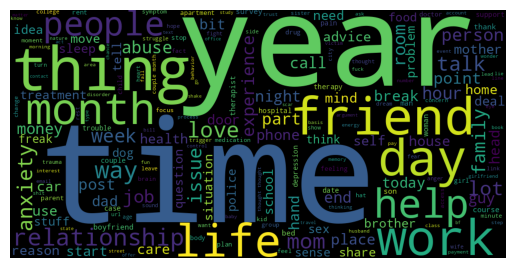

In [27]:
wc = WordCloud(width=1000, height=500).generate(noun_text)

plt.imshow(wc)
plt.axis('off')
plt.show()


##TASK 3: TEXT CLASSIFICATION

In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [29]:
train = pd.read_csv("train_clean.csv")
val = pd.read_csv("val_clean.csv")
test = pd.read_csv("test_clean.csv")


In [30]:
X_train = train['clean_text']
y_train = train['labs']

X_val = val['clean_text']
y_val = val['labs']


In [31]:
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)


In [32]:
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=200)

In [33]:
y_pred = model.predict(X_val_tfidf)


In [34]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Accuracy: 0.8255506607929516
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       540
           1       0.82      0.86      0.84       595

    accuracy                           0.83      1135
   macro avg       0.83      0.82      0.82      1135
weighted avg       0.83      0.83      0.83      1135



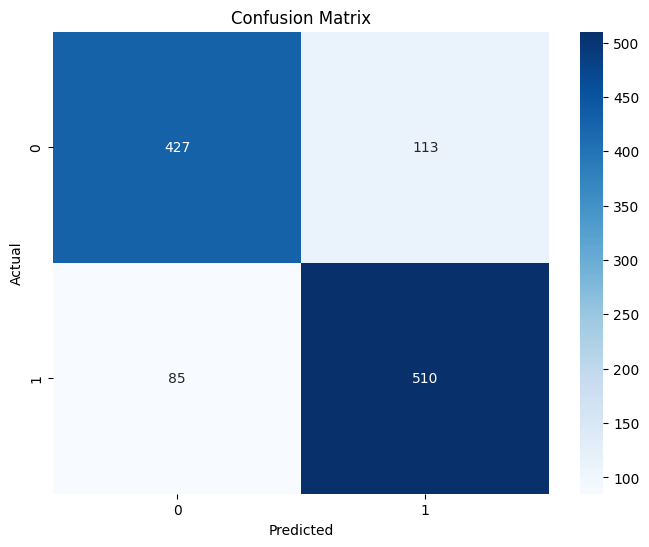

In [35]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [36]:
X_test = test['clean_text']
X_test_tfidf = tfidf.transform(X_test)

test_preds = model.predict(X_test_tfidf)


In [37]:
test['predicted_label'] = test_preds
test.to_csv("test_with_predictions.csv", index=False)
